In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions,Session
import time

In [14]:
# Load saved credentials
service = QiskitRuntimeService()

qiskit_runtime_service.__init__:INFO:2025-06-13 10:52:02,940: Default instance: ibm-q/open/main


In [15]:
def generate_graph(num_nodes, edge_prob=0.5):
    return nx.erdos_renyi_graph(num_nodes, edge_prob)

In [16]:
# QUBO conversion and Hamiltonian construction
def create_qubo_hamiltonian(graph, num_colors=3):
    num_nodes = graph.number_of_nodes()
    Q = np.zeros((num_nodes * num_colors, num_nodes * num_colors))
    for i in range(num_nodes):
        for c in range(num_colors):
            Q[i * num_colors + c, i * num_colors + c] -= 1
            for cp in range(c + 1, num_colors):
                Q[i * num_colors + c, i * num_colors + cp] += 2
    for i, j in graph.edges():
        for c in range(num_colors):
            Q[i * num_colors + c, j * num_colors + c] += 1
    Q = 0.5 * (Q + Q.T)
    linear = np.diag(Q)
    quadratic = Q - np.diag(linear)
    h = {i: linear[i] for i in range(len(linear))}
    J = {(i, j): quadratic[i, j] for i in range(len(linear)) for j in range(i + 1, len(linear)) if quadratic[i, j] != 0}
    
    pauli_list = []
    for (i, j), weight in J.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        z_p[j] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    for i, weight in h.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    hamiltonian = sum([SparsePauliOp.from_list([(pauli.to_label(), weight)]) for pauli, weight in pauli_list])
    
    return hamiltonian

In [17]:
# Callback to count evaluations and iterations
evaluation_count = 0
iteration_count = 0

def optimizer_callback(eval_count):
    global evaluation_count, iteration_count
    evaluation_count = eval_count
    iteration_count += 1

In [18]:
from collections import defaultdict

qaoa_total_sample_time_per_node = defaultdict(float)


In [19]:
# Callback to count evaluations and iterations
evaluation_count = 0
iteration_count = 0
qaoa_exec_time = 0
qaoa_times1=[]
iteration_times =[]
simulation_time = 0
def optimizer_callback(eval_count,paramters,mean,metadata):
    global evaluation_count, iteration_count,qaoa_exec_time,simulation_time
    iteration_times.append((metadata['simulator_metadata']['sample_measure_time']))
    qaoa_exec_time+=(metadata['simulator_metadata']['sample_measure_time'])
    iteration_count += 1
    simulation_time+=(metadata['simulator_metadata']['time_taken'])
    # print(f"Metadata: {metadata}")

In [20]:
def run_qaoa(graph, p=3, max_iter=500, shots=1024):
    global evaluation_count, iteration_count,qaoa_exec_time,simulation_time
    evaluation_count = 0
    iteration_count = 0
    qaoa_exec_time = 0
    simulation_time = 0 
    hamiltonian = create_qubo_hamiltonian(graph)
    optimizer = COBYLA(maxiter=max_iter, tol=1e-6, disp=True)
    
    base_sampler = Sampler(backend_options={"method": "automatic", "device": "CPU"},
        run_options={"shots": 1024, "seed": 42})
    
    qaoa = QAOA(optimizer=optimizer, reps=p, sampler=base_sampler, callback=optimizer_callback)
    
    # Measure the time for the QAOA execution
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    
    return qaoa_exec_time,evaluation_count, iteration_count, result, hamiltonian, qaoa,simulation_time  # Create QAOA instance

In [21]:
def dsatur_coloring(graph):
    coloring = {}
    saturation_degrees = {node: 0 for node in graph.nodes()}
    available_colors = [True] * len(graph.nodes())
    iterations = 0
    while len(coloring) < len(graph.nodes()):
        iterations += 1
        uncolored_nodes = [node for node in graph.nodes() if node not in coloring]
        max_saturation = -1
        selected_node = None
        for node in uncolored_nodes:
            if saturation_degrees[node] > max_saturation:
                max_saturation = saturation_degrees[node]
                selected_node = node
            elif saturation_degrees[node] == max_saturation:
                if selected_node is None or graph.degree[node] > graph.degree[selected_node]:
                    selected_node = node
        neighbor_colors = {coloring[neighbor] for neighbor in graph.neighbors(selected_node) if neighbor in coloring}
        for color in range(len(available_colors)):
            if color not in neighbor_colors:
                coloring[selected_node] = color
                break
        for neighbor in graph.neighbors(selected_node):
            if neighbor not in coloring:
                saturation_degrees[neighbor] += 1
    return coloring, iterations

In [22]:
def run_dsatur(graph):
    start_time = time.time()
    _, classical_iter = dsatur_coloring(graph)
    classical_time = time.time() - start_time
    return classical_time, classical_iter

In [23]:
# Initialize lists to store the results
num_nodes_list = []
qaoa_times = []
qaoa_iterations = []
qaoa_evaluations = []
classical_times = []
classical_iterations = []
results = []
hamiltonians = []
simulation_times = []

In [ ]:
import logging

# Configure logging
logging.basicConfig(filename='graph_coloring_results.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')  # 'w' to overwrite each time

# Run experiments and log
# for num_nodes in range(3, 10): 
#     G = generate_graph(num_nodes)
#     pos = nx.spring_layout(G)
#     qaoa_time, qaoa_eval, qaoa_iter = run_qaoa(G)
#     # classical_time, classical_iter = run_dsatur(G)
    
#     # Collect results
#     num_nodes_list.append(num_nodes)
#     qaoa_iterations.append(qaoa_iter)
#     qaoa_evaluations.append(qaoa_eval)
    # classical_times.append(classical_time)
    # classical_iterations.append(classical_iter)

    # Generate and run algorithms on graphs with increasing sizes
for num_nodes in range(3, 11): 
    G = generate_graph(num_nodes)
    qaoa_exec_time, qaoa_eval, qaoa_iter, result, hamiltonian, qaoa,simulation_time = run_qaoa(G)
    
    # Collect results
    num_nodes_list.append(num_nodes)
    qaoa_times.append(qaoa_exec_time)
    qaoa_iterations.append(qaoa_iter)
    qaoa_evaluations.append(qaoa_eval)
    results.append(result)
    hamiltonians.append(hamiltonian)
    simulation_times.append(simulation_time)
    
    # Log results
    logging.info(f"Nodes: {num_nodes}  "
                 f"QAOA sim Time - Time: {qaoa_exec_time}seconds, Iter: {qaoa_iterations}  "
                 f"QAOA results: {result}")




KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

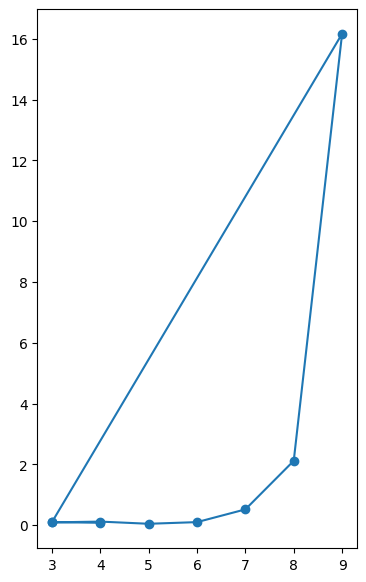

In [26]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot execution times
plt.subplot(1, 3, 1)
plt.plot(num_nodes_list, qaoa_times, label='Quantum (QAOA)', marker='o')
plt.plot(num_nodes_list, classical_times, label='Classical (DSATUR)', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. Number of Nodes')
plt.legend()

# Plot number of iterations
plt.subplot(1, 3, 2)
plt.plot(num_nodes_list, qaoa_iterations, label='Quantum (QAOA)', marker='o')
plt.plot(num_nodes_list, classical_iterations, label='Classical (DSATUR)', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations vs. Number of Nodes')
plt.legend()

# Plot evaluation counts
plt.subplot(1, 3, 3)
plt.plot(num_nodes_list, qaoa_evaluations, label='Quantum (QAOA)', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Evaluations')
plt.title('Number of Evaluations vs. Number of Nodes')
plt.legend()

plt.tight_layout()
plt.show()